# DCGAN Example for Custom Datasets

## Generate anime faces with a few lines of code!

This project is a basic introduction to Deep Convolutional Generative Adversarial Networks in Keras and TensorFlow 2. In this example, you will use the Anime Faces dataset, with 64*64 size images. However, because of the use of Keras' ImageDataGenerator, you will be able to implement any custom dataset into this model (with 64 by 64 images). Later in the tutorial, you will learn how to implement DCGANs on different resolutions. This notebook is made to be ran on Google Colab's GPUs for a faster training.

In [2]:
# import libraries

import tensorflow as tf
from tensorflow import keras # Keras Deep Learning library
from matplotlib import pyplot as plt # plotting library to show images
import numpy as np # linear algebra and array manipulation

import urllib.request # to fetch the dataset from the internet
import zipfile # to unzip the dataset
from IPython import display # virtual display to plot the images

In [3]:
# function to plot example generated images

def plot_results(images, n_cols=None):
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols*2, n_rows*2))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [4]:
import os
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

# download the zipped dataset to the data directory
data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

### Image Generation Constants

This cell specifies the images' size (IMAGE_SIZE by IMAGE_SIZE) and the batch size when training. Try playing with the batch size for different results! For simplicity, this notebook uses a batch size of 32 and an image size of 64, which is the main size of the imported images.

In [5]:
IMAGE_SIZE = 64
BATCH_SIZE = 32

In [9]:
# this is where our dataset is stored, so we will use this path for the ImageDataGenerator
!ls /tmp/anime/
path = '/tmp/anime/'

images


In [71]:
# create an image generator to augment our data
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.05,
    rotation_range = 5,
    horizontal_flip = True
)

In [72]:
# import dataset to train the DCGAN with the predefined path
image_dataset_generator = data_generator.flow_from_directory(
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    color_mode = 'rgb',
    class_mode = None,
    batch_size = BATCH_SIZE,
    directory = path
)

Found 63565 images belonging to 1 classes.


In [73]:
len(image_dataset_generator) # we have 1987 image batches, with 32 images each.

1987

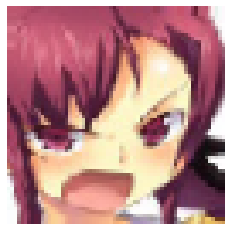

In [74]:
# plot example image
plt.axis(False)
for i in image_dataset_generator:
  plt.imshow(np.array(i[0]))
  break

## DCGAN

A DCGAN uses Convolutional layers when training, hence its name (Deep Convolutional Generative Adversarial Network).

When creating a DCGAN, a common practice is to use Convolutional Transposed layers for the generator from a random seed in a Gaussian distribution until it matches the real images' size.

Also, the seed passes through a Dense layer to be used by our Conv2DTranspose layers. You can add more layers, but they need to have a stride size of 1, because then the strides done by the other layers will match the output.

If your dataset is grayscale, you will need an output of 1 filter, and if it's RGB (like in this example), the output layer will have 3 filters for each channel (Red, Green, Blue).

The comments in each layer describe how our resolution goes up by each transposing layer.

In [78]:
# generator function (random_dimensions = random seed vector size)
random_dimensions = 32


generator = keras.models.Sequential()
generator.add(keras.layers.Dense(512*4*4, input_shape = [random_dimensions]))
generator.add(keras.layers.Reshape([4, 4, 512]))
generator.add(keras.layers.BatchNormalization(momentum = 0.5))
generator.add(keras.layers.Conv2DTranspose(filters = 128, kernel_size = 4, strides = 2, padding = 'same', activation = 'selu')) #8*8*128
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = 'same', activation = 'selu')) #16*16*64
generator.add(keras.layers.BatchNormalization(momentum = 0.5))
generator.add(keras.layers.Conv2DTranspose(32, kernel_size = 4, strides = 2, padding = 'same', activation = 'selu')) #32*32*32
generator.add(keras.layers.BatchNormalization(momentum = 0.5))
generator.add(keras.layers.Conv2DTranspose(3, kernel_size = 4, strides = 2, padding = 'same', activation = 'tanh')) # 64*64*3

In [79]:
generator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 8192)              270336    
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose_37 (Conv2DT (None, 8, 8, 128)         1048704   
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_38 (Conv2DT (None, 16, 16, 64)        131136    
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 64)      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


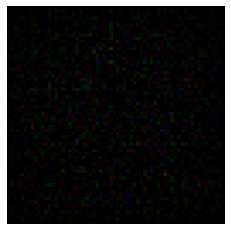

In [80]:
# generator without training
seed = tf.random.normal([1, random_dimensions])
gen_image = generator(seed)
# plot the image
plt.axis(False)
plt.imshow(np.reshape(gen_image, (64, 64, 3)))

In [81]:
# discriminator part of DCGAN
discriminator = keras.models.Sequential()
discriminator.add(keras.layers.Conv2D(32, 5, 2, padding = 'same', input_shape = [64, 64, 3])) # 32*32*32
discriminator.add(keras.layers.LeakyReLU(alpha = 0.2))
discriminator.add(keras.layers.Conv2D(64, 5, 2, padding = 'same')) # 16*16*64
discriminator.add(keras.layers.LeakyReLU(alpha = 0.2))
discriminator.add(keras.layers.Conv2D(128, 5, 2, padding = 'same')) # 8*8*128
discriminator.add(keras.layers.LeakyReLU(alpha = 0.2))
discriminator.add(keras.layers.Conv2D(256, 5, 2, padding = 'same')) # 4*4*256
discriminator.add(keras.layers.LeakyReLU(alpha = 0.2))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [82]:
# discriminator summary
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)       

In [83]:
# compile and freeze the discriminator
discriminator.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5), loss = 'binary_crossentropy')
discriminator.trainable = False

In [84]:
# declare and compile DCGAN
gan = keras.models.Sequential([generator, discriminator])
gan.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5), loss = 'binary_crossentropy')

In [86]:
# training function for custom datasets
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for i in range(len(dataset)):
            real_images = dataset.next()
            real_batch_size = real_images.shape[0]
            # random noise
            noise = tf.random.normal(shape = [real_batch_size, random_normal_dimensions])
          # Use the noise to generate fake images
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images, real_images], axis = 0)
            discriminator_labels = tf.constant([[0.]]*real_batch_size + [[1.]]*real_batch_size)
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            # PHASE 2 OF TRAINING
            noise = tf.random.normal([real_batch_size, random_normal_dimensions])
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]]*real_batch_size)
            # Freeze the discriminator
            discriminator.trainable = False
            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
            fake_images = np.clip(fake_images, 0, 1)
        plot_results(np.array(fake_images), 16)                     
        plt.show()
    return fake_images

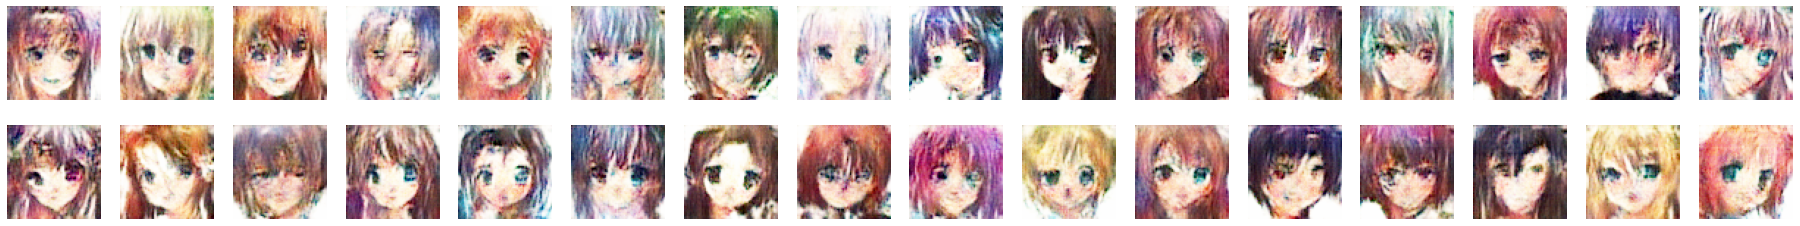

In [87]:
# finally, train the model
EPOCHS = 5

# run the training loop and collect images
fake_images = train_gan(gan, image_dataset_generator, 32, EPOCHS)

### Conclusions and Task

As you can see, implementing a DCGAN in Keras isn't as hard as it seems! For simple datasets like this one, great results can be achieved with a relatively low amount of training. Try experimenting with the layers parameters to see if you can get a better result!